In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

from collections import defaultdict
from pathlib import Path
import pandas as pd
import numpy as np
from typing import *

import statsmodels
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import boxcox
from scipy.special import inv_boxcox

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

pio.renderers.default = "iframe"

In [2]:
base_path = "/data/saturation/central_composite_design/ccd9"
base_path_holdout = "/data/saturation/central_composite_design/ccd9_holdout"

ivs = ["slope", "effective_radius_multiplier", "r_stat_multiplier", "min_rim_percentage", "n_craters_in_study_region", "z", "za", "areal_density"]

In [3]:
sample_size = 1000

train_df = pd.read_csv(f"{base_path}/sample_{sample_size}.csv")
train_df["z"] = train_df.z.fillna(0)
train_df["za"] = train_df.za.fillna(0)
train_df["information_lost"] = (1 - train_df.n_craters_in_study_region / train_df.n_craters_added_in_study_region).fillna(0)

# First test_df contains simulations that are near the vertices of the CCD
# Second test_df contains simulations that are in the midpoints of CCD levels
test_dfs = [
    pd.read_csv(f"{base_path}/in_sample_holdout_sample_{sample_size}.csv"),
    pd.read_csv(f"{base_path_holdout}/sample_{sample_size}.csv")
]

for test_df in test_dfs:
    test_df["z"] = test_df.z.fillna(0)
    test_df["za"] = test_df.za.fillna(0)
    test_df["information_lost"] = (1 - test_df.n_craters_in_study_region / test_df.n_craters_added_in_study_region).fillna(0)

metric = "information_lost"

### Linear regression models

In [4]:
def fit_and_report_statsmodels_glm_model(family: sm.families.Family,
                                         X_train,
                                         y_train,
                                         X_tests,
                                         y_tests,
                                         model_name):
    model = sm.GLM(y_train, X_train, family=family).fit()
    print(model.summary())

    y_pred = model.predict(X_train)
    rmse = mean_squared_error(y_pred, y_train, squared=False)
    mape = mean_absolute_percentage_error(y_pred, y_train)
    print(f"***** {model_name} *****")
    print(f"Train RMSE: {rmse:.4f}, Train MAPE: {mape:.4f}")

    residuals = y_train - y_pred
    plt.hist(residuals, bins=50)
    plt.show()

    ks_norm_p = stats.kstest(residuals, cdf=stats.norm.cdf).pvalue
    ad_result = stats.anderson(residuals, dist="norm")
    print(f"KS test p-value on training residuals: {ks_norm_p:.3f}")
    print(f"AD test on training residuals: {ad_result.statistic:.3f}, critical values: {ad_result.critical_values}, significance levels: {ad_result.significance_level}")

    for indx, (X_test, y_test) in enumerate(zip(X_tests, y_tests)):
        print(f"*** Test set {indx + 1}")
        y_pred = model.predict(X_test)
        rmse = mean_squared_error(y_pred, y_test, squared=False)
        mape = mean_absolute_percentage_error(y_pred, y_test)
        print(f"Test RMSE: {rmse:.4f}, Test MAPE: {mape:.4f}")

        y_pred_mean_model = [y_train.mean()] * len(y_test)
        rmse = mean_squared_error(y_pred_mean_model, y_test, squared=False)
        mape = mean_absolute_percentage_error(y_pred_mean_model, y_test)
        print(f"Mean model: RMSE: {rmse:.4f}, MAPE: {mape:.4f}")
    
    return model

In [5]:
def fit_and_report_statsmodels_model(model_creator: Callable[[pd.DataFrame, pd.DataFrame], Any],
                                     X_train,
                                     y_train,
                                     X_tests,
                                     y_tests,
                                     model_name,
                                     transform=lambda x: x,
                                     inverse_transform=lambda x: x):
    y_train_transformed = transform(y_train)
    
    model = model_creator(y_train_transformed, X_train).fit()
    print(model.summary())

    y_pred = inverse_transform(model.predict(X_train))
    rmse = mean_squared_error(y_pred, y_train, squared=False)
    mape = mean_absolute_percentage_error(y_pred, y_train)
    print(f"***** {model_name} *****")
    print(f"Train RMSE: {rmse:.4f}, Train MAPE: {mape:.4f}")

    residuals = y_train - y_pred
    plt.hist(residuals, bins=50)
    plt.show()

    ks_norm_p = stats.kstest(residuals, cdf=stats.norm.cdf).pvalue
    ad_result = stats.anderson(residuals, dist="norm")
    print(f"KS test p-value on training residuals: {ks_norm_p:.3f}")
    print(f"AD test on training residuals: {ad_result.statistic:.3f}, critical values: {ad_result.critical_values}, significance levels: {ad_result.significance_level}")

    for indx, (X_test, y_test) in enumerate(zip(X_tests, y_tests)):
        print(f"*** Test set {indx + 1}")
        y_pred = inverse_transform(model.predict(X_test))
        rmse = mean_squared_error(y_pred, y_test, squared=False)
        mape = mean_absolute_percentage_error(y_pred, y_test)
        print(f"Test RMSE: {rmse:.4f}, Test MAPE: {mape:.4f}")

        y_pred_mean_model = [y_train.mean()] * len(y_test)
        rmse = mean_squared_error(y_pred_mean_model, y_test, squared=False)
        mape = mean_absolute_percentage_error(y_pred_mean_model, y_test)
        print(f"Mean model: RMSE: {rmse:.4f}, MAPE: {mape:.4f}")
    
    return model

#### Checking scatterplots

In [6]:
params_df = train_df[["simulation_id", "slope", "min_rim_percentage", "effective_radius_multiplier", "r_stat_multiplier"]].drop_duplicates()
# params_df[params_df.simulation_id == 26]
params_df

,simulation_id,slope,min_rim_percentage,effective_radius_multiplier,r_stat_multiplier
0,5,1.012659,0.248303,1.299621,2.973998
40,69,0.999135,0.749762,1.501115,2.972541
80,92,0.995535,0.374520,1.103174,4.530270
120,317,0.985872,0.372550,1.104048,9.014610
200,593,1.485676,0.749965,1.505079,6.041076
...,...,...,...,...,...
157467,1334,2.489710,0.626713,1.904390,5.960479
158147,453,1.493918,0.255169,1.099730,4.489649
158507,933,2.012335,0.496945,1.095209,5.961801
166780,1613,2.989421,0.496453,1.492561,4.466332


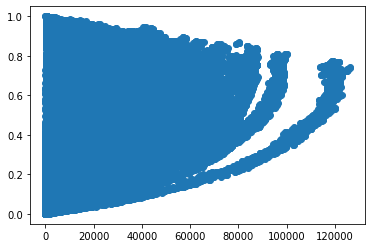

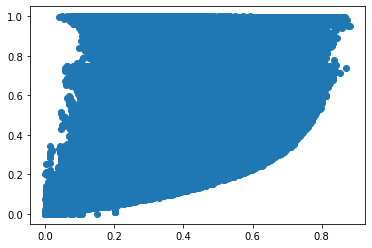

In [7]:
data = train_df

plt.scatter(data.n_craters_in_study_region, data.information_lost)
plt.show()

plt.scatter(data.areal_density, data.information_lost)
plt.show()

In [8]:
# Normalize for coloring plot markers
data["marker_size"] = 1
hover_data = {
    "slope": ":.3f",
    "effective_radius_multiplier": ":.3f",
    "r_stat_multiplier": ":.3f",
    "min_rim_percentage": ":.3f",
    metric : ":.3f"
}
fig = px.scatter_matrix(
    data,
    dimensions=["n_craters_in_study_region", "za", "areal_density", "slope", "effective_radius_multiplier", "min_rim_percentage"],
    hover_data=hover_data,
    color="information_lost",
    size="marker_size",
    size_max=5,
    width=800,
    height=600
)
fig.show()

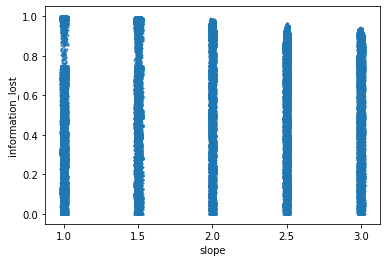

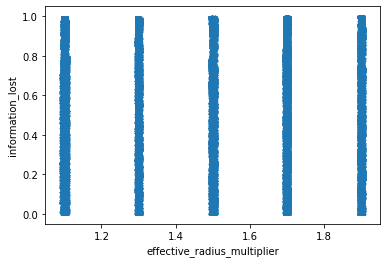

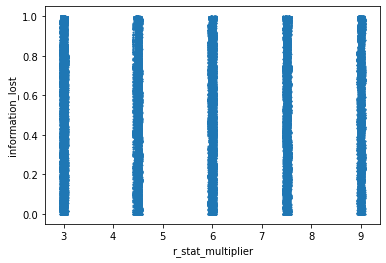

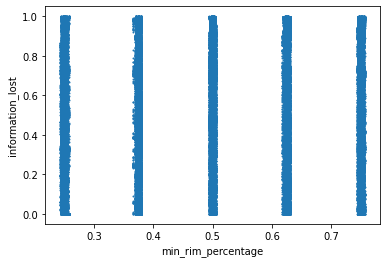

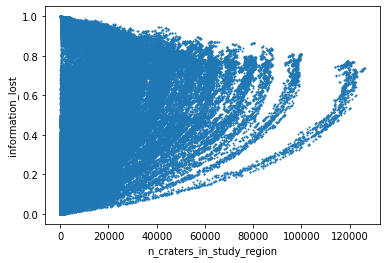

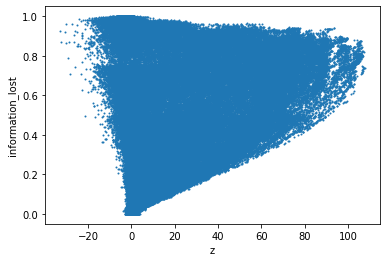

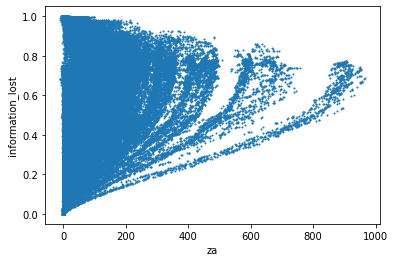

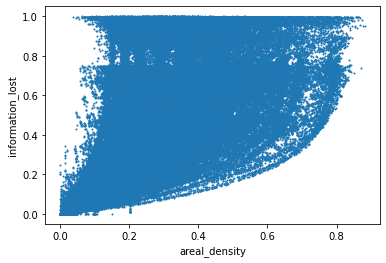

In [9]:
series = train_df[metric]

for iv in ivs:
    plt.scatter(train_df[iv], series, s=1)
    plt.xlabel(iv)
    plt.ylabel(metric)
    plt.show()

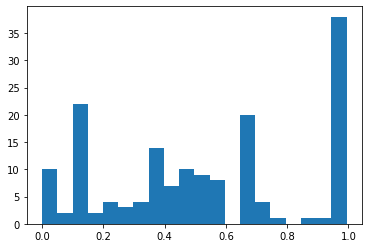

In [10]:
plt.hist(train_df[train_df.simulation_id == 444][metric], bins=20)
plt.show()

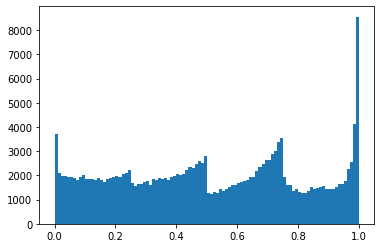

In [11]:
plt.hist(train_df[metric], bins=100)
plt.show()

### Baseline Linear Regression Model

In [ ]:
features = ["za", "areal_density", "n_craters_in_study_region"]
X_train = train_df[features]
X_tests = [x[features] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

model = fit_and_report_statsmodels_model(lambda y, x: sm.OLS(y, x),
                                         sm.add_constant(X_train),
                                         y_train,
                                         [sm.add_constant(x) for x in X_tests],
                                         y_tests,
                                         "LM No Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

In [ ]:
features = ["za", "areal_density", "n_craters_in_study_region"]

X_train = train_df[features]
X_tests = [x[features] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]

model = fit_and_report_statsmodels_model(lambda y, x: sm.OLS(y, x),
                                         sm.add_constant(X_train),
                                         y_train,
                                         [sm.add_constant(x) for x in X_tests],
                                         y_tests,
                                         "LM No Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

In [ ]:
X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

model = fit_and_report_statsmodels_model(lambda y, x: sm.OLS(y, x),
                                         sm.add_constant(X_train),
                                         y_train,
                                         [sm.add_constant(x) for x in X_tests],
                                         y_tests,
                                         "LM No Interactions",
                                         transform=sm.families.links.Logit(),
                                         inverse_transform=sm.families.links.Logit().inverse)

In [ ]:
X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

model = fit_and_report_statsmodels_model(lambda y, x: sm.GLM(y, x, family=sm.families.Gaussian()),
                                         sm.add_constant(X_train),
                                         y_train,
                                         [sm.add_constant(x) for x in X_tests],
                                         y_tests,
                                         "LM No Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

### With Interactions

In [ ]:
exclude = {}

features = [x for x in ivs if x not in exclude]

X_train = train_df[features]
X_tests = [x[features] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]

model = fit_and_report_statsmodels_model(lambda y, x: sm.GLM(y, x, family=sm.families.Binomial(link=sm.families.links.Logit())),
                                         sm.add_constant(X_train),
                                         y_train,
                                         [sm.add_constant(x) for x in X_tests],
                                         y_tests,
                                         "LM With Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

#### Removing Insignificant Variables

In [ ]:
add_const = True

exclude = {
    "r_stat_multiplier za", # p-value
    "r_stat_multiplier n_craters_in_study_region", # p-value
    "r_stat_multiplier areal_density", # p-value
    "slope za", # p-value
    "", # p-value
    "", # p-value
    "", # p-value
    "", # p-value
    "", # p-value
}

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

model = fit_and_report_statsmodels_model(lambda y, x: sm.GLM(y, x, family=sm.families.Binomial(link=sm.families.links.Logit())),
                                         sm.add_constant(X_train),
                                         y_train,
                                         [sm.add_constant(x) for x in X_tests],
                                         y_tests,
                                         "GLM With Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

In [ ]:
import statsmodels.api as sm
from sklearn.base import BaseEstimator, RegressorMixin

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_creator_func, fit_kwargs={}):
        self.model_creator_func = model_creator_func
        self.fit_kwargs = fit_kwargs
        
    def fit(self, X, y):
        self.model_ = self.model_creator_func(y, X)
        self.results_ = self.model_.fit(**self.fit_kwargs)
        return self
    
    def predict(self, X):
        return self.results_.predict(X)
    
    @property
    def coef_(self):
        return self.results_.params

In [ ]:
exclude = {}

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

In [ ]:
min_features_to_select = 1 
model = SMWrapper(lambda y, x: sm.GLM(y, x, family=sm.families.Binomial(link=sm.families.links.Logit())))
cv = KFold(5)

rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    min_features_to_select=min_features_to_select,
    n_jobs=1
)
rfecv.fit(X_train, y_train)

In [ ]:
model = fit_and_report_statsmodels_model(lambda y, x: sm.GLM(y, x, family=sm.families.Binomial(link=sm.families.links.Logit())),
                                         sm.add_constant(X_train[rfecv.get_feature_names_out()]),
                                         y_train,
                                         [sm.add_constant(x[rfecv.get_feature_names_out()]) for x in X_tests],
                                         y_tests,
                                         "LM With RFE Features",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

In [ ]:
# Checking effect sizes
max_coef = max([abs(x) for x, y in zip(model.params, model.params.index) if y != "const"])
sorted([(abs(x / max_coef), y) for x, y in zip(model.params, model.params.index)])

In [ ]:
# Checking highest p-value
model.pvalues.sort_values(ascending=False)

### Trying a Gaussian GLM with Log Link

                            OLS Regression Results                            
Dep. Variable:       information_lost   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     3873.
Date:                Tue, 13 Jun 2023   Prob (F-statistic):               0.00
Time:                        16:50:49   Log-Likelihood:            -5.2871e+05
No. Observations:              198786   AIC:                         1.057e+06
Df Residuals:                  198748   BIC:                         1.058e+06
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

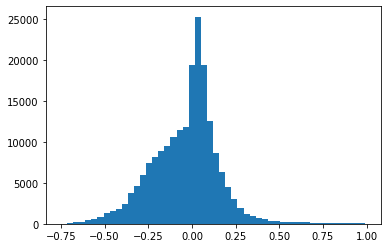

KS test p-value on training residuals: 0.000
AD test on training residuals: 1642.931, critical values: [0.576 0.656 0.787 0.918 1.092], significance levels: [15.  10.   5.   2.5  1. ]
*** Test set 1
Test RMSE: 0.1928, Test MAPE: 46.1020
Mean model: RMSE: 0.2994, MAPE: 0.5067
*** Test set 2
Test RMSE: 0.1865, Test MAPE: 18.7681
Mean model: RMSE: 0.3097, MAPE: 0.5245


In [12]:
add_const = True

exclude = {
    "effective_radius_multiplier r_stat_multiplier", # effect size
    "r_stat_multiplier min_rim_percentage", # effect size
    "slope r_stat_multiplier", # effect size
    "r_stat_multiplier^2", # effect size
    "slope effective_radius_multiplier", # effect size
    "r_stat_multiplier", # effect size
    "min_rim_percentage^2", # effect size
    "", # effect size
    "", # effect size
    "", # effect size
}

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

model = fit_and_report_statsmodels_model(lambda y, x: sm.OLS(y, x),
                                         sm.add_constant(X_train),
                                         y_train,
                                         [sm.add_constant(x) for x in X_tests],
                                         y_tests,
                                         "LM With Interactions",
                                         transform=sm.families.links.Logit(),
                                         inverse_transform=sm.families.links.Logit().inverse)

In [ ]:
# Checking effect sizes
max_coef = max([abs(x) for x, y in zip(model.params, model.params.index) if y != "const"])
sorted([(abs(x / max_coef), y) for x, y in zip(model.params, model.params.index)])

In [ ]:
# Checking highest p-value
model.pvalues.sort_values(ascending=False)

### Trying Poisson GLM with log link

In [ ]:
add_const = True

exclude = {
    "effective_radius_multiplier r_stat_multiplier", # effect size
    "r_stat_multiplier min_rim_percentage", # effect size
    "slope r_stat_multiplier", # effect size
    "r_stat_multiplier^2", # effect size
    "slope effective_radius_multiplier", # effect size
    "r_stat_multiplier", # effect size
    "min_rim_percentage^2", # effect size
    "", # effect size
    "", # effect size
    "", # effect size
}

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

model = fit_and_report_statsmodels_glm_model(sm.families.Poisson(link=sm.families.links.Log()),
                                             sm.add_constant(X_train),
                                             y_train,
                                             [sm.add_constant(x) for x in X_tests],
                                             y_tests,
                                             "GLM With Interactions")

In [ ]:
# Checking effect sizes
max_coef = max([abs(x) for x, y in zip(model.params, model.params.index) if y != "const"])
sorted([(abs(x / max_coef), y) for x, y in zip(model.params, model.params.index)])

### Trying with degree=3

In [ ]:
exclude = {
    "slope r_stat_multiplier min_rim_percentage", # p-value
    "r_stat_multiplier^2 min_rim_percentage", # effect size
    "const", # effect size
    "effective_radius_multiplier r_stat_multiplier min_rim_percentage", # effect size
    "slope r_stat_multiplier^2", # effect size
    "slope^2 r_stat_multiplier", # effect size
    "slope effective_radius_multiplier r_stat_multiplier", # effect size
    "", # effect size
    "", # effect size
    "", # effect size
    "", # effect size
}

X_train = train_df[ivs]
X_tests = [x[ivs] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=3, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())
X_train = X_train[[x for x in X_train.columns if x not in exclude]]

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]
X_tests = [x[[y for y in x.columns if y not in exclude]] for x in X_tests]

model = fit_and_report_statsmodels_model(sm.OLS,
                                         X_train,
                                         y_train,
                                         X_tests,
                                         y_tests,
                                         "LM With Reduced Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

In [ ]:
# Checking effect sizes
max_coef = max([abs(x) for x, y in zip(model.params, model.params.index) if y != "const"])
sorted([(abs(x / max_coef), y) for x, y in zip(model.params, model.params.index)])

In [ ]:
# Checking highest p-value
model.pvalues.sort_values(ascending=False)

### Plotting Prediction Intervals

In [35]:
def read_simulation_parquet(path: Path, sample_cadence: int) -> pd.DataFrame:
    df = pd.read_parquet(path, columns=ivs + ["simulation_id", "n_craters_added_in_study_region"])
    df = df.iloc[[x * sample_cadence for x in range(df.shape[0] // sample_cadence)]].copy()
    df["z"] = df.z.fillna(0)
    df["za"] = df.za.fillna(0)
    df["information_lost"] = (1 - df.n_craters_in_study_region / df.n_craters_added_in_study_region).fillna(0)
    return df


def score_model(model,
                df: pd.DataFrame,
                metric: str,
                transform,
                inverse_transform,
                add_constant: bool) -> pd.DataFrame:
    X = df[ivs]
    X = min_max_scaler.transform(X)
    X = pd.DataFrame(X, columns=min_max_scaler.get_feature_names_out())
    
    X = poly_transform.transform(X)
    X = pd.DataFrame(X, columns=poly_transform.get_feature_names_out())

    pred_df = df.reset_index(drop=True).copy()
    for feature_name in poly_transform.get_feature_names_out():
        pred_df[feature_name] = X[feature_name]
    
    X = X[feature_names].copy()
    y = transform(df[metric])
    
    if add_constant:
        X = sm.add_constant(X, has_constant="add")
    pred_df["actual"] = list(df[metric])
    pred_df["n_craters"] = list(df.index)
    pred_df["predicted"] = list(inverse_transform(model.predict(X)))
    
    return pred_df


def score_model_from_parquet_file(model,
                                  parquet_path: Path,
                                  sample_cadence: int,
                                  metric: str,
                                  transform,
                                  inverse_transform,
                                  add_constant: bool) -> pd.DataFrame:
    df = read_simulation_parquet(parquet_path, sample_cadence)
    return score_model(model, df, metric, transform, inverse_transform, add_constant)


def plot_holdout_sim_ci(model,
                        parquet_path: Path,
                        sample_cadence: int,
                        metric: str,
                        transform,
                        inverse_transform,
                        add_constant):
    pred_df = score_model_from_parquet_file(model, parquet_path, sample_cadence, metric, transform, inverse_transform, add_constant)
    
    # Show params
    print(f"Simulation parameters: {pred_df[ivs].iloc[0]}")

    ns_max = 100000
    plt.plot(pred_df.n_craters_added_in_study_region.iloc[:ns_max],
             pred_df[metric].iloc[:ns_max])
    plt.xlabel("$N_G$")
    plt.ylabel("$Predicted$")
    plt.show()
    
    fig = go.Figure()

    fig.add_scatter(x=pred_df["n_craters"],
                    y=pred_df["actual"],
                    mode="lines",
                    name="Actual")
    
    fig.add_scatter(x=pred_df["n_craters"],
                    y=pred_df["predicted"],
                    mode="lines",
                    name=f"Predicted")

    fig.update_layout(
        xaxis_title="$N_G$",
        yaxis_title=metric
    )

    fig.show()
    

def plot_holdout_sim(model,
                     parquet_path: Path,
                     sample_cadence: int,
                     metric: str,
                     transform,
                     inverse_transform,
                     add_constant):
    pred_df = score_model_from_parquet_file(model, parquet_path, sample_cadence, metric, transform, inverse_transform, add_constant)
    
    # Show params
    print(f"Simulation parameters: {pred_df[ivs].iloc[0]}")
    
    fig = go.Figure()

    fig.add_scatter(x=pred_df["n_craters"],
                    y=pred_df["actual"],
                    mode="lines",
                    name="Actual")
    
    fig.add_scatter(x=pred_df["n_craters"],
                    y=pred_df["predicted"],
                    mode="lines",
                    name=f"Predicted")

    fig.update_layout(
        xaxis_title="$N_G$",
        yaxis_title=metric
    )

    fig.show()

In [14]:
# Load up a subset of the test DFs
np.random.seed(123)

sample_cadence = 100
in_ccd_paths = list(Path(base_path).glob("simulation_*.parquet"))
outside_ccd_paths = list(Path(base_path_holdout).glob("simulation_*.parquet"))

In [22]:
from statsmodels.othermod.betareg import BetaModel

                              BetaModel Results                               
Dep. Variable:                      y   Log-Likelihood:             1.4548e+05
Model:                      BetaModel   AIC:                        -2.909e+05
Method:            Maximum Likelihood   BIC:                        -2.904e+05
Date:                Tue, 13 Jun 2023                                         
Time:                        18:30:11                                         
No. Observations:              198786                                         
Df Residuals:                  198740                                         
Df Model:                          44                                         
                                                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
const                                        

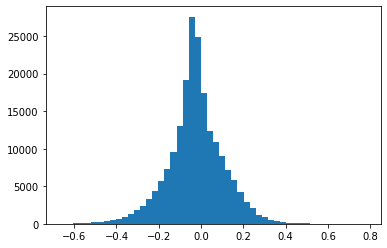

KS test p-value on training residuals: 0.000
AD test on training residuals: 1203.474, critical values: [0.576 0.656 0.787 0.918 1.092], significance levels: [15.  10.   5.   2.5  1. ]
*** Test set 1
Test RMSE: 0.1320, Test MAPE: 0.2238
Mean model: RMSE: 0.2994, MAPE: 0.5067
*** Test set 2
Test RMSE: 0.1297, Test MAPE: 0.2245
Mean model: RMSE: 0.3097, MAPE: 0.5245


In [32]:
exclude = {
}

features = [x for x in ivs if x not in exclude]
feature_names = ivs

X_train = train_df[features]
X_tests = [x[features] for x in test_dfs]

y_train = train_df[metric]
y_tests = [x[metric] for x in test_dfs]

min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=min_max_scaler.get_feature_names_out())

poly_transform = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train = poly_transform.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=poly_transform.get_feature_names_out())

X_tests = [pd.DataFrame(min_max_scaler.transform(x), columns=min_max_scaler.get_feature_names_out()) for x in X_tests]
X_tests = [poly_transform.transform(x) for x in X_tests]
X_tests = [pd.DataFrame(x, columns=poly_transform.get_feature_names_out()) for x in X_tests]

# model = fit_and_report_statsmodels_model(lambda y, x: sm.GLM(y, x, family=sm.families.Binomial(link=sm.families.links.Logit())),
#                                          sm.add_constant(X_train),
#                                          y_train,
#                                          [sm.add_constant(x) for x in X_tests],
#                                          y_tests,
#                                          "LM With Interactions",
#                                          transform=lambda x: x,
#                                          inverse_transform=lambda x: x)

# model = fit_and_report_statsmodels_model(lambda y, x: sm.OLS(y, x),
#                                          sm.add_constant(X_train),
#                                          y_train,
#                                          [sm.add_constant(x) for x in X_tests],
#                                          y_tests,
#                                          "LM No Interactions",
#                                          transform=sm.families.links.Logit(),
#                                          inverse_transform=sm.families.links.Logit().inverse)

y_train = np.where(y_train == 0, 0.0001, y_train)
y_train = np.where(y_train == 1, 0.9999, y_train)

model = fit_and_report_statsmodels_model(lambda y, x: BetaModel(y, x),
                                         sm.add_constant(X_train),
                                         y_train,
                                         [sm.add_constant(x) for x in X_tests],
                                         y_tests,
                                         "LM No Interactions",
                                         transform=lambda x: x,
                                         inverse_transform=lambda x: x)

In [37]:
feature_names = [x for x in model.model.exog_names if x != "const" and x != "precision"]
data = score_model(model, train_df, metric, lambda x: x, True)
print(f"Kurtosis: ", stats.kurtosis(data.actual - data["predicted"]))

TypeError: score_model() missing 1 required positional argument: 'add_constant'

In [38]:
# Visualize CIs for a few in-CCD simulations
for x in range(10, 15):
    print(x)
    plot_holdout_sim(model, in_ccd_paths[x], sample_cadence, metric, transform=lambda x: x, inverse_transform=lambda x: x, add_constant=True)

10
Simulation parameters: slope                          0.012245
effective_radius_multiplier    0.744781
r_stat_multiplier              0.987823
min_rim_percentage             0.013625
n_craters_in_study_region      0.000000
z                              0.234209
za                             0.010037
areal_density                  0.000003
Name: 0, dtype: float64


11
Simulation parameters: slope                          4.998769e-01
effective_radius_multiplier    9.884957e-01
r_stat_multiplier              9.878231e-01
min_rim_percentage             9.873977e-01
n_craters_in_study_region      0.000000e+00
z                              2.342085e-01
za                             1.003669e-02
areal_density                  6.810916e-07
Name: 0, dtype: float64


12
Simulation parameters: slope                          0.743693
effective_radius_multiplier    0.257352
r_stat_multiplier              0.987823
min_rim_percentage             0.743954
n_craters_in_study_region      0.000000
z                              0.234209
za                             0.010037
areal_density                  0.000002
Name: 0, dtype: float64


13
Simulation parameters: slope                          0.012245
effective_radius_multiplier    0.988496
r_stat_multiplier              0.499513
min_rim_percentage             0.500511
n_craters_in_study_region      0.000000
z                              0.234209
za                             0.010037
areal_density                  0.000005
Name: 0, dtype: float64


14
Simulation parameters: slope                          0.743693
effective_radius_multiplier    0.257352
r_stat_multiplier              0.987823
min_rim_percentage             0.987398
n_craters_in_study_region      0.000000
z                              0.234209
za                             0.010037
areal_density                  0.000011
Name: 0, dtype: float64


In [ ]:
# Visualize CIs for a few simulations outside the CCD
for x in range(10, 15):
    print(x)
    plot_holdout_sim_ci(model, outside_ccd_paths[x], sample_cadence, metric, inverse_transform=lambda x: x, add_constant=True)

In [ ]:
# Model residuals for training data
pred_df = score_model(model, train_df, metric, lambda x: x, True)

resid = pred_df.actual - pred_df["predicted"]

plt.scatter(pred_df[metric], resid)
plt.xlabel("$A_d$")
plt.ylabel("Residual")
plt.show()

for iv in ivs:
    if iv in pred_df.columns:
        plt.scatter(pred_df[iv], resid)
        plt.xlabel(iv)
        plt.ylabel("Residual")
        plt.show()